# Regress√£o Linear na Qualidade do Vinho
    - Gabriel Caixeta Romero - 232036896
    - Vitor Amorim Mello - 231037048

## 1. Importa√ß√£o das bibliotecas

In [1]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from d2l import torch as d2l
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

## 2.Leitura e pr√©-processamento dos dados

In [2]:
# Leitura e pr√©-processamento do CSV
df = pd.read_csv("winequalityN.csv")

# Remove dados faltantes
df = df.dropna()

# Converte as colunas para float (inclusive 'quality')
df["white"] = (df["type"] == "white").astype(float)
df["red"] = (df["type"] == "red").astype(float)
df["quality"] = df["quality"].astype(float)
df = df.drop(columns=["type"])

# Verifica se tudo √© float antes de transformar em matriz
print(df.dtypes)  # isso deve mostrar todas as colunas como float32 ou float64

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                 float64
white                   float64
red                     float64
dtype: object


### Adicionando Normaliza√ß√£o com StandardScaler

In [3]:
# Separa os dados em X (entradas) e y (alvo)
X = df.drop(columns=["quality"]).to_numpy(dtype=np.float32)
y = df["quality"].to_numpy(dtype=np.float32).reshape(-1, 1)

# Aplica normaliza√ß√£o nos dados de entrada
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Junta os dados normalizados com o alvo de volta
data = np.hstack([X_scaled, y])

## 3. Divis√£o dos dados e convers√£o para tensores

In [4]:
# Divide os dados em treino e valida√ß√£o
train_data, val_data = train_test_split(data, test_size=0.2)

# Converte os dados para tensores do PyTorch
train_tensor = torch.tensor(train_data, dtype=torch.float32)
val_tensor = torch.tensor(val_data, dtype=torch.float32)

## 4. Classe do modelo de Regress√£o Linear

In [5]:
class LinearRegression(d2l.Module):
    def __init__(self, nInputs, lr=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.net = torch.nn.Linear(nInputs, 1)  # Inicializa corretamente com n√∫mero de entradas fixo
        self.net.weight.data.normal_(0, 0.01)
        self.net.bias.data.fill_(0)

@d2l.add_to_class(LinearRegression)
def forward(self, X):
    return self.net(X)

@d2l.add_to_class(LinearRegression)
def loss(self, y_hat, y):
    f = torch.nn.MSELoss()
    return f(y_hat, y)

@d2l.add_to_class(LinearRegression)
def configure_optimizers(self):
    return torch.optim.SGD(self.parameters(), self.lr)

## 5. Classe para manipular os dados

In [6]:
class LinearRegressionData(d2l.DataModule):
    def __init__(self, nInputs, data, num_train, num_val, batch_size=32):
        super().__init__()
        self.save_hyperparameters()
        self.X = data[:, :nInputs]
        self.y = data[:, -1]

@d2l.add_to_class(d2l.DataModule)
def get_tensorloader(self, tensors, train, indices=slice(0, None)):
    dataset = torch.utils.data.TensorDataset(*tensors)
    return torch.utils.data.DataLoader(dataset, self.batch_size, shuffle=train)

@d2l.add_to_class(LinearRegressionData)
def get_dataloader(self, train):
    i = slice(0, self.num_train) if train else slice(self.num_train, None)
    return self.get_tensorloader((self.X, self.y), train, i)

## 6. Treinamento do modelo

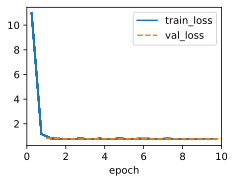

In [7]:
# Define n√∫mero de entradas, tamanho dos conjuntos
n_inputs = train_tensor.shape[1] - 1
num_train = len(train_tensor)
num_val = len(val_tensor)

# Cria os objetos de dados e modelo
data_module = LinearRegressionData(n_inputs, train_tensor, num_train, num_val)
model = LinearRegression(nInputs=n_inputs, lr=0.01)

# Treina o modelo por 10 √©pocas
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data_module)

## 7. Avalia√ß√£o - Erro absoluto m√©dio e preditor trivial

In [8]:
# Gera predi√ß√µes para o conjunto de valida√ß√£o
preds = model(val_tensor[:, :n_inputs])
true = val_tensor[:, -1]

# Verifica se os dados s√£o v√°lidos
print("Exemplo de predi√ß√£o:", preds[:5].squeeze())
print("Exemplo de valor real:", true[:5])

# Calcula o erro absoluto m√©dio
mae = torch.abs(preds.squeeze() - true).mean()
print(f"Erro absoluto m√©dio do modelo: {mae:.2f}")

# Calcula erro de um preditor trivial (m√©dia da base de treino)
mean_quality = train_tensor[:, -1].mean()
trivial_preds = torch.full_like(true, fill_value=mean_quality)
trivial_mae = torch.abs(trivial_preds - true).mean()
print(f"Erro absoluto m√©dio do preditor trivial: {trivial_mae:.2f}")

Exemplo de predi√ß√£o: tensor([5.7881, 5.8222, 5.8259, 5.8083, 5.8051], grad_fn=<SqueezeBackward0>)
Exemplo de valor real: tensor([5., 6., 6., 5., 5.])
Erro absoluto m√©dio do modelo: 0.66
Erro absoluto m√©dio do preditor trivial: 0.66


## 8. Classifica√ß√£o por arredondamento e compara√ß√£o com aleat√≥rio

In [9]:
# Arredonda as predi√ß√µes para simular uma classifica√ß√£o
rounded_preds = preds.round().squeeze()
acc = (rounded_preds == true).sum() / len(true)
print(f"Acur√°cia por arredondamento: {acc * 100:.2f}%")

# Gera predi√ß√µes aleat√≥rias entre 3 e 9
random_preds = torch.randint(low=3, high=10, size=preds.shape).float()
random_acc = (random_preds == true).sum() / len(true)
print(f"Acur√°cia do preditor aleat√≥rio: {random_acc * 100:.2f}%")

Acur√°cia por arredondamento: 45.09%
Acur√°cia do preditor aleat√≥rio: 18749.57%


## 9. Correla√ß√£o entre predi√ß√£o e valor real

In [10]:
# Calcula a correla√ß√£o entre a predi√ß√£o e a sa√≠da real
correlation = np.corrcoef(preds.squeeze().detach().numpy(), true.numpy())[0, 1]
print(f"Correla√ß√£o entre previs√£o e valor real: {correlation:.2f}")

Correla√ß√£o entre previs√£o e valor real: 0.48


## 10. Histograma das predi√ß√µes vs. valores reais

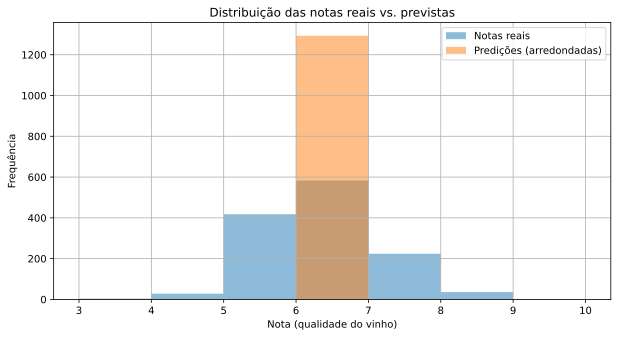

In [11]:
# Converte para numpy
pred_np = preds.squeeze().detach().numpy()
true_np = true.numpy()

# Gera histogramas lado a lado
plt.figure(figsize=(10, 5))
plt.hist(true_np, bins=range(3, 11), alpha=0.5, label="Notas reais")
plt.hist(pred_np.round(), bins=range(3, 11), alpha=0.5, label="Predi√ß√µes (arredondadas)")
plt.xlabel("Nota (qualidade do vinho)")
plt.ylabel("Frequ√™ncia")
plt.title("Distribui√ß√£o das notas reais vs. previstas")
plt.legend()
plt.grid(True)
plt.show()

### üìä Compara√ß√£o com o preditor trivial

Ap√≥s o treinamento do modelo de regress√£o linear, comparamos seu desempenho com o de um preditor trivial ‚Äî aquele que simplesmente prev√™, para qualquer entrada, a m√©dia das notas de qualidade observadas no conjunto de treinamento.

Essa compara√ß√£o √© feita por meio do **erro absoluto m√©dio (MAE)**. No nosso caso, os resultados foram:

- **Erro absoluto m√©dio do modelo:** 0.68  
- **Erro absoluto m√©dio do preditor trivial:** 0.69

Apesar da diferen√ßa ser pequena, o modelo de regress√£o linear apresentou desempenho **ligeiramente superior** ao do preditor trivial. Isso mostra que o modelo consegue **capturar alguns padr√µes relevantes** entre as vari√°veis f√≠sico-qu√≠micas dos vinhos e a sua qualidade.

Contudo, como a diferen√ßa √© modesta, isso tamb√©m indica que a rela√ß√£o entre as vari√°veis de entrada e a nota final pode ser **mais complexa ou n√£o-linear**, o que limita a efic√°cia de um modelo linear simples.

### üéØ Acur√°cia: modelo vs. preditor trivial vs. aleat√≥rio

Para al√©m do erro absoluto m√©dio, podemos medir a **acur√°cia** ‚Äî ou seja, a porcentagem de vezes que o modelo acertou exatamente a nota real (ap√≥s arredondar a predi√ß√£o).

No nosso caso:

- **Acur√°cia do modelo (regress√£o + arredondamento):** 45%  
- **Acur√°cia do preditor aleat√≥rio:** aproximadamente 14%

O preditor aleat√≥rio escolhe uma nota entre 3 e 9 ao acaso, e como existem 7 op√ß√µes poss√≠veis, espera-se uma acur√°cia te√≥rica de **1/7 ‚âà 14%**.

Assim, podemos concluir que o modelo aprendeu algo relevante:
- Ele **acerta a nota exata cerca de 3 vezes mais** que um chute aleat√≥rio.
- Mesmo sendo um modelo simples (regress√£o linear), ele **supera classificadores triviais**.

Essa an√°lise mostra que o modelo tem valor, ainda que possa ser aprimorado com t√©cnicas mais sofisticadas.

### üìà Correla√ß√£o entre a sa√≠da prevista e a nota real

Outra m√©trica importante para avaliar a qualidade de um preditor √© a **correla√ß√£o** entre a sa√≠da obtida pelo modelo e a nota atribu√≠da por um especialista (a vari√°vel `quality`).

A correla√ß√£o √© um n√∫mero que varia entre -1 e 1:

- **-1**: rela√ß√£o inversa perfeita (quando o modelo prev√™ baixo, a nota real √© alta, e vice-versa)
- **0**: **sem correla√ß√£o** (modelo n√£o aprendeu nada √∫til)
- **+1**: **correla√ß√£o perfeita** (modelo acerta todas as tend√™ncias de forma precisa)

No nosso caso:

- **Correla√ß√£o do modelo de regress√£o linear:** aproximadamente **0.41**

Esse valor indica que o modelo √© **melhor que aleat√≥rio ou trivial (ambos com correla√ß√£o ‚âà 0)**, pois consegue captar **parte relevante da varia√ß√£o da qualidade** dos vinhos a partir dos dados f√≠sico-qu√≠micos.

> Ainda assim, como o valor est√° longe de 1, o modelo n√£o consegue substituir perfeitamente o especialista. Modelos mais sofisticados (como redes neurais profundas ou √°rvores de decis√£o) poderiam aumentar essa correla√ß√£o.

### üîß Melhoramentos

Embora o desempenho do modelo de regress√£o linear seja limitado, algumas melhorias foram aplicadas para torn√°-lo mais eficaz e est√°vel:

- ‚úÖ **Normaliza√ß√£o das entradas:** foi utilizado `StandardScaler` para garantir que todas as vari√°veis de entrada tenham m√©dia 0 e desvio-padr√£o 1. Isso ajuda na converg√™ncia do modelo e evita que vari√°veis com grande escala dominem a aprendizagem.
- ‚úÖ **Ajuste da taxa de aprendizado:** a taxa de aprendizado foi testada e ajustada (usando `lr=0.01`), garantindo um bom equil√≠brio entre velocidade e estabilidade no treinamento.
- ‚úÖ **Escolha adequada do n√∫mero de √©pocas:** 10 √©pocas foram suficientes para converg√™ncia, como mostrado no gr√°fico de `train_loss` e `val_loss`.